In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import importlib
import wrds
import os

import wrds_loader

In [5]:
sp_500 = wrds_loader.download_snp_constituents()
sp_500

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
0,36127.0,1999-01-04,2001-02-26,2000-01-31,0.130178,FIRSTAR CORP NEW WIS,33763V10,1998-11-20,2000-05-31,11.0,1.0,6712.0,FSR,004723,01,LC,P,1972-12-14,2001-02-26 00:00:00.000000
1,78083.0,1998-10-02,2004-12-28,2000-01-31,0.055718,PEOPLESOFT INC,71271310,1992-11-19,2004-06-09,11.0,3.0,7370.0,PSFT,025944,01,LU,P,1992-11-19,2005-01-31 00:00:00.000000
3,12060.0,1957-03-01,2022-12-30,2000-01-31,-0.136511,GENERAL ELECTRIC CO,36960410,1968-01-02,2000-02-29,11.0,1.0,3511.0,GE,005047,01,LC,P,1962-01-31,2023-10-08 12:11:39.558476
5,23114.0,1989-08-24,2012-06-29,2000-01-31,0.076468,CAROLINA POWER & LIGHT CO,14414110,1968-01-02,2000-06-19,11.0,1.0,4911.0,CPL,002783,01,LU,P,1962-01-31,2012-06-30 00:00:00.000000
7,26403.0,1976-07-01,2022-12-30,2000-01-31,0.241453,DISNEY WALT CO,25468710,1996-02-12,2001-09-27,11.0,1.0,4833.0,DIS,003980,01,LC,P,1962-01-31,2023-10-08 12:11:39.558476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175130,75607.0,2003-03-31,2022-12-30,2022-12-30,-0.066638,GEN DIGITAL INC,66877110,2022-11-08,2022-12-30,11.0,3.0,7372.0,GEN,015855,01,LC,P,1989-06-23,2023-10-08 12:11:39.558476
175131,84381.0,1996-12-09,2022-12-30,2022-12-30,-0.025168,ROCKWELL AUTOMATION INC,77390310,2017-04-10,2022-12-30,11.0,1.0,3621.0,ROK,009203,01,LC,P,1996-12-16,2023-10-08 12:11:39.558476
175133,22517.0,1995-11-27,2022-12-30,2022-12-30,-0.002541,P P L CORP,69351T10,2020-05-04,2022-12-30,11.0,1.0,4813.0,PPL,008455,01,LC,P,1962-01-31,2023-10-08 12:11:39.558476
175134,81655.0,1995-05-30,2022-12-30,2022-12-30,-0.058916,DARDEN RESTAURANTS INC,23719410,2014-07-21,2022-12-30,11.0,1.0,5812.0,DRI,031846,01,LC,P,1995-05-30,2023-10-08 12:11:39.558476


In [22]:
importlib.reload(wrds_loader)
tickers = sp_500['ticker'].unique()
conn = wrds.Connection()
for ticker in tickers:
    data = wrds_loader.download_stock_data_crsp([ticker], conn=conn)
    data.to_feather(f'returns/{ticker}.feather')
conn.close()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


#### Momentum

In [2]:
eps = 10 ** (-5)
def rolling_prod(series, window):
    """
    Compute rolling product over a window for a given series.
    """
    # Compute rolling product for entire series first
    rolling_cumprod = series.cumprod()

    # Compute rolling product over a given window by dividing the rolling cumprod at
    # the end of the window by the rolling cumprod at the beginning of the window
    return rolling_cumprod / rolling_cumprod.shift(window)

def calc_momentum(feather_path, spy_momentum=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])
    
    df['momentum'] = rolling_prod((1+df['ret']), 11 * 20) - 1
    df['momentum'] = df['momentum'].shift(20)
    
    if spy_momentum is not None:
        df = pd.merge(df, spy_momentum, on='date', how='inner')
        df['risk_adj_momentum'] = (eps + df['momentum']) / (eps + df['spy_momentum'])
    return df

# Load and preprocess SPY data
spy = calc_momentum('returns/SPY.feather')
spy = spy[['date', 'momentum']]
spy.columns = ['date', 'spy_momentum']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_momentum(file_path, spy_momentum=spy)
    df = df[['ticker', 'date', 'momentum', 'risk_adj_momentum']]
    df.to_feather(f'factors/momentum/{filename}')
    print(f'{filename} Done')

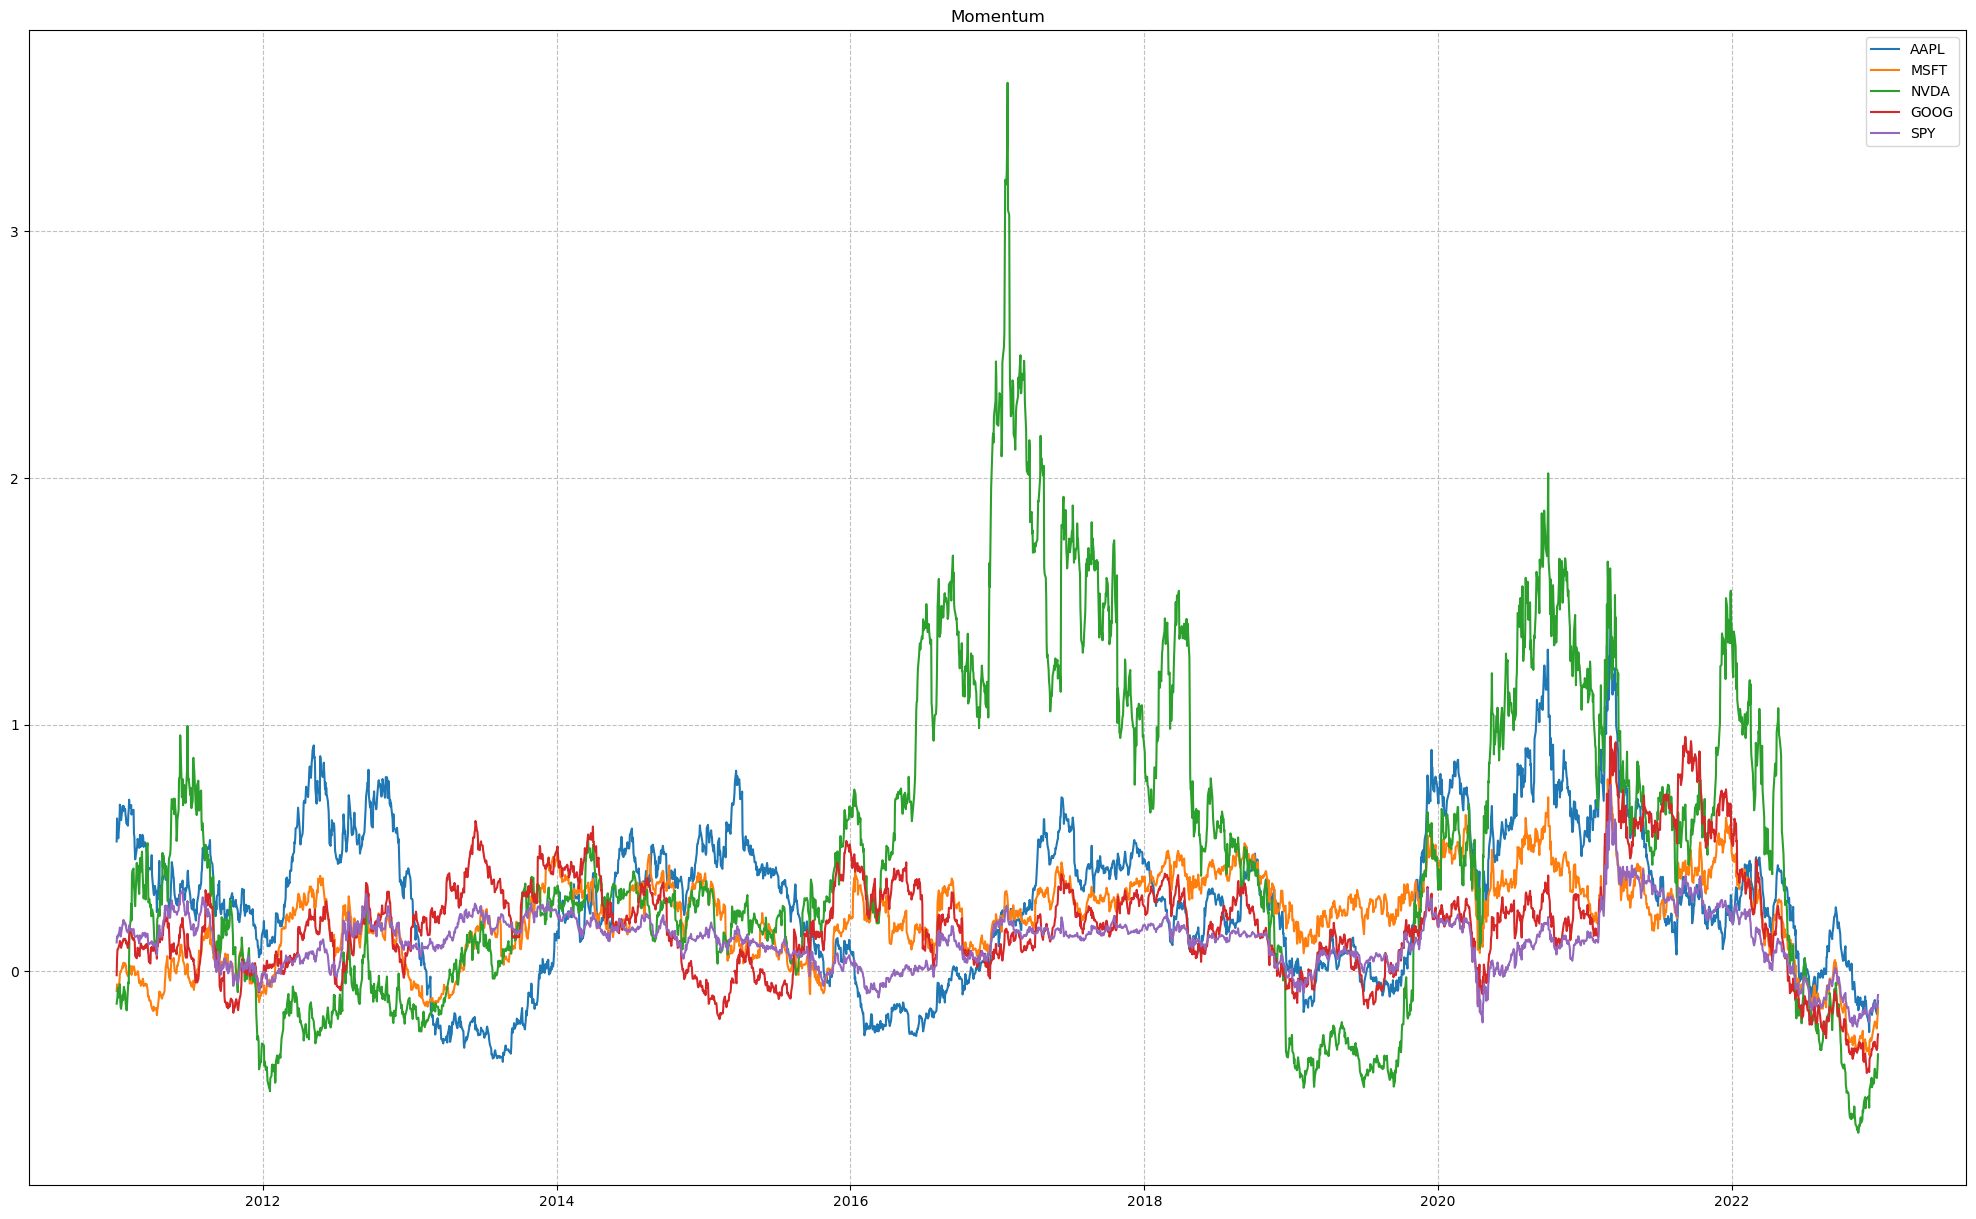

In [13]:
aapl = pd.read_feather('factors/momentum/AAPL.feather')
msft = pd.read_feather('factors/momentum/MSFT.feather')
nvda = pd.read_feather('factors/momentum/NVDA.feather')
goog = pd.read_feather('factors/momentum/GOOG.feather')
spy = pd.read_feather('factors/momentum/SPY.feather')

aapl = aapl[aapl['date'].dt.year > 2010]
msft = msft[msft['date'].dt.year > 2010]
nvda = nvda[nvda['date'].dt.year > 2010]
goog = goog[goog['date'].dt.year > 2010]
spy = spy[spy['date'].dt.year > 2010]

plt.figure(figsize=(25,15))
plt.title('Momentum')
plt.grid(linestyle='--', color='silver')

plt.plot(aapl['date'], aapl['momentum'], label='AAPL')
plt.plot(msft['date'], msft['momentum'], label='MSFT')
plt.plot(nvda['date'], nvda['momentum'], label='NVDA')
plt.plot(goog['date'], goog['momentum'], label='GOOG')
plt.plot(spy['date'], spy['momentum'], label='SPY')

plt.legend()
plt.show()

#### 1 month reversal

In [11]:
def calc_reversal(feather_path, spy_reversal=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])

    df['1M_reversal*'] = (1/rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    df['1M_reversal'] = (-rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    
    if spy_reversal is not None:
        df = pd.merge(df, spy_reversal, on='date', how='inner')
        df['risk_adj_1M_reversal'] = (eps + df['1M_reversal']) / (eps + df['spy_1M_reversal'])
        df['risk_adj_1M_reversal*'] = (eps + df['1M_reversal*']) / (eps + df['spy_1M_reversal*'])
    return df

# Load and preprocess SPY data
spy = calc_reversal('returns/SPY.feather')
spy = spy[['date', '1M_reversal', '1M_reversal*']]
spy.columns = ['date', 'spy_1M_reversal', 'spy_1M_reversal*']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_reversal(file_path, spy_reversal=spy)
    df = df[['ticker', 'date', '1M_reversal', '1M_reversal*', 'risk_adj_1M_reversal', 'risk_adj_1M_reversal*']]
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(f'factors/1_month_reversal/{filename}')
    print(f'{filename} Done')

A.csv Done
AA.csv Done
AAL.csv Done
AAP.csv Done
AAPL.csv Done
ABBV.csv Done
ABC.csv Done
ABI.csv Done
ABK.csv Done
ABMD.csv Done
ABS.csv Done
ABT.csv Done
ABX.csv Done
ACAS.csv Done
ACE.csv Done
ACGL.csv Done
ACK.csv Done
ACN.csv Done
ACS.csv Done
ACT.csv Done
ACV.csv Done
ADBE.csv Done
ADCT.csv Done
ADI.csv Done
ADM.csv Done
ADNT.csv Done
ADP.csv Done
ADPT.csv Done
ADS.csv Done
ADSK.csv Done
ADT.csv Done
AEE.csv Done
AEP.csv Done
AES.csv Done
AET.csv Done
AFL.csv Done
AFS.csv Done
AGC.csv Done
AGN.csv Done
AHC.csv Done
AHP.csv Done
AIG.csv Done
AIV.csv Done
AIZ.csv Done
AJG.csv Done
AKAM.csv Done
AKS.csv Done
AL.csv Done
ALB.csv Done
ALGN.csv Done
ALK.csv Done
ALL.csv Done
ALLE.csv Done
ALTR.csv Done
ALXN.csv Done
AM.csv Done
AMAT.csv Done
AMCC.csv Done
AMCR.csv Done
AMD.csv Done
AME.csv Done
AMG.csv Done
AMGN.csv Done
AMP.csv Done
AMR.csv Done
AMT.csv Done
AMZN.csv Done
AN.csv Done
ANDV.csv Done
ANDW.csv Done
ANET.csv Done
ANF.csv Done
ANR.csv Done
ANSS.csv Done
ANTM.csv Done
AOC.cs

MEA.csv Done
MEDI.csv Done
MEE.csv Done
MEL.csv Done
MER.csv Done
MERQ.csv Done
MET.csv Done
META.csv Done
MFE.csv Done
MGM.csv Done
MHFI.csv Done
MHK.csv Done
MHP.csv Done
MHS.csv Done
MI.csv Done
MIL.csv Done
MIR.csv Done
MJN.csv Done
MKC.csv Done
MKG.csv Done
MKTX.csv Done
MLM.csv Done
MMC.csv Done
MMI.csv Done
MMM.csv Done
MNK.csv Done
MNST.csv Done
MO.csv Done
MOH.csv Done
MOLX.csv Done
MON.csv Done
MOS.csv Done
MOT.csv Done
MPC.csv Done
MPWR.csv Done
MRK.csv Done
MRNA.csv Done
MRO.csv Done
MS.csv Done
MSCI.csv Done
MSFT.csv Done
MSI.csv Done
MTB.csv Done
MTC.csv Done
MTCH.csv Done
MTD.csv Done
MTG.csv Done
MTW.csv Done
MU.csv Done
MUR.csv Done
MWD.csv Done
MWV.csv Done
MWW.csv Done
MXIM.csv Done
MYG.csv Done
MYL.csv Done
MZ.csv Done
N.csv Done
NAV.csv Done
NAVI.csv Done
NBL.csv Done
NBR.csv Done
NC.csv Done
NCC.csv Done
NCE.csv Done
NCLH.csv Done
NCR.csv Done
NDAQ.csv Done
NDSN.csv Done
NE.csv Done
NEE.csv Done
NEM.csv Done
NFB.csv Done
NFLX.csv Done
NFX.csv Done
NGH.csv Done
NI.

#### Financial Ratios

In [10]:
importlib.reload(wrds_loader)
directory_path = 'returns'
files = os.listdir(directory_path)
conn = wrds.Connection()
for filename in files:
    ticker = filename.split(".")[0]
    data = wrds_loader.download_finratios(ticker, db=conn)
    data.to_csv(f'factors/finratios/{ticker}.csv')
    print(f'{ticker} Done')
conn.close()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
A Done
AA Done
AAL Done
AAP Done
AAPL Done
ABBV Done
ABC Done
ABI Done
ABK Done
ABMD Done
ABS Done
ABT Done
ABX Done
ACAS Done
ACE Done
ACGL Done
ACK Done
ACN Done
ACS Done
ACT Done
ACV Done
ADBE Done
ADCT Done
ADI Done
ADM Done
ADNT Done
ADP Done
ADPT Done
ADS Done
ADSK Done
ADT Done
AEE Done
AEP Done
AES Done
AET Done
AFL Done
AFS Done
AGC Done
AGN Done
AHC Done
AHP Done
AIG Done
AIV Done
AIZ Done
AJG Done
AKAM Done
AKS Done
AL Done
ALB Done
ALGN Done
ALK Done
ALL Done
ALLE Done
ALTR Done
ALXN Done
AM Done
AMAT Done
AMCC Done
AMCR Done
AMD Done
AME Done
AMG Done
AMGN Done
AMP Done
AMR Done
AMT Done
AMZN Done
AN Done
ANDV Done
ANDW Done
ANET Done
ANF Done
ANR Done
ANSS Done
ANTM Done
AOC Done
AOL Done
AON Done
AOS Do

SCHW Done
SDS Done
SE Done
SEBL Done
SEDG Done
SEE Done
SEG Done
SFA Done
SGI Done
SGP Done
SHLD Done
SHW Done
SIAL Done
SIG Done
SII Done
SIVB Done
SJM Done
SLB Done
SLE Done
SLG Done
SLM Done
SLR Done
SMI Done
SMS Done
SNA Done
SNDK Done
SNI Done
SNPS Done
SNV Done
SO Done
SOTR Done
SOV Done
SPC Done
SPG Done
SPGI Done
SPLS Done
SPY Done
SRCL Done
SRE Done
SRV Done
SSP Done
STA Done
STE Done
STI Done
STJ Done
STLD Done
STR Done
STT Done
STX Done
STZ Done
SUB Done
SUN Done
SUNW Done
SV Done
SVU Done
SWK Done
SWKS Done
SWN Done
SWY Done
SYF Done
SYK Done
SYMC Done
SYY Done
T Done
TAN Done
TAP Done
TDC Done
TDG Done
TDY Done
TE Done
TECH Done
TEG Done
TEK Done
TEL Done
TER Done
TEX Done
TFC Done
TFX Done
TGNA Done
TGT Done
THC Done
TIE Done
TIF Done
TIN Done
TJX Done
TKR Done
TLAB Done
TMC Done
TMK Done
TMO Done
TMPW Done
TMUS Done
TNB Done
TOS Done
TOY Done
TPR Done
TRB Done
TRGP Done
TRIP Done
TRMB Done
TROW Done
TRV Done
TRW Done
TSCO Done
TSG Done
TSLA Done
TSN Done
TSO Done
TSS Don